#Multi-Armed Bandit
In this exercise session we will consider the UCB1 and TS algorithms as examples of frequentist
and Bayesian MAB algorithms, respectively, for the solutions of the stochastic
MAB problem.

Let us instantiate a stochastic MAB environment with 5 arms with Bernoulli reward:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Set the environment
exp_reward = np.array([0.15, 0.1, 0.1, 0.2, 0.35, 0.2])
n_arms = len(exp_reward)
opt = np.max(exp_reward)
idx_opt = np.argmax(exp_reward)
deltas = opt - exp_reward
deltas = np.array([delta for delta in deltas if delta > 0])

#Time horizon
T = 5000

Recall that in this example we are aware of the environment, while in real-world applications we do not have the model of the environment, therefore selecting the optimal arm is not a viable operation.

Instead, we want to resort to an online approach to minimize the loss due to the learning of the optimal arm.

## UCB1
As a first algorithm we will implement the UCB1 algorithm, which uses **upper confidence bounds** to select the arm to pull for the next round.

We recap here the main steps of the algorithm:
- For each time step $t$
- Compute $\hat{R}_t(a_l) = \frac{\sum_{j = 1}^{t-1} r_{a_{i_j},j} \ \boldsymbol{1} \left\{ a_{i_j} = a_{l} \right\}}{N_t(a_l) } \ \ \forall a_l$
- Compute $B_t(a_l) = \sqrt{\frac{2\log t}{N_t(a_l)}} \ \ \forall a_l$
- Play arm $a_{i_t} = \arg \max_{a_l \in \mathcal{A}} \left\{ \hat{R}_t(a_l) + B_t(a_l) \right\}$

After the execution of the algorithm we would like to evaluate its performances.
In this
case, as usual in the MAB literature, we resort to the concept of expected pseudo-regret:
$$L_T = T R^* - \mathbb{E} \left[ \sum_{t = 1}^T R(a_{i_t}) \right] = \sum_{a_i \in \mathcal{A} : \Delta_i > 0} \mathbb{E}[N_T(a_i)] \Delta_i$$

A first approximated version of the regret can be computed as follows:
$$\tilde{L}_T = \sum_{t = 1}^T [r_{a^*}-r_{a_{i_t}}]$$


Let's see how it can be implemented:


In [ ]:
def UCB1():
  ucb1_criterion = np.zeros(n_arms)
  expected_payoffs = np.zeros(n_arms)
  number_of_pulls = np.zeros(n_arms)

  regret = np.array([])
  pseudo_regret = np.array([])

  for t in range(T):
      #Select an arm
      if t < n_arms:
        pulled_arm = t  # round robin for the first n steps
      else:
        idxs = np.argwhere(ucb1_criterion == ucb1_criterion.max()).reshape(-1)  # there can be more arms with max value
        pulled_arm = np.random.choice(idxs) #arbitrary

      #Pull an arm
      reward = np.random.binomial(1, exp_reward[pulled_arm]) #Bernoulli reward
      if pulled_arm != idx_opt:
        reward_opt = np.random.binomial(1, exp_reward[idx_opt])
      else:
        reward_opt = reward

      #Update UCB1
      number_of_pulls[pulled_arm] = number_of_pulls[pulled_arm] + 1
      expected_payoffs[pulled_arm] = ((expected_payoffs[pulled_arm] * (number_of_pulls[pulled_arm] - 1.0) + reward) /
                                      number_of_pulls[pulled_arm]) # update sample mean for the selected arm
      if t >= n_arms:
        for k in range(0, n_arms):
          ucb1_criterion[k] = expected_payoffs[k] + np.sqrt(2 * np.log(t) / number_of_pulls[k])

      #Store results
      regret = np.append(regret, reward_opt - reward)
      pseudo_regret = np.append(pseudo_regret, opt - exp_reward[pulled_arm])
  return regret, pseudo_regret

In [ ]:
regret, pseudo_regret = UCB1()

An example of the execution of the UCB1 algorithm is available at:
https://drive.google.com/file/d/1OMDBpbvCldsXdnBnnXGZIoZNDfchHoj1/view?usp=sharing

Here we compare the approximated regret with the expected pseudo-regret we obtained with a single run:

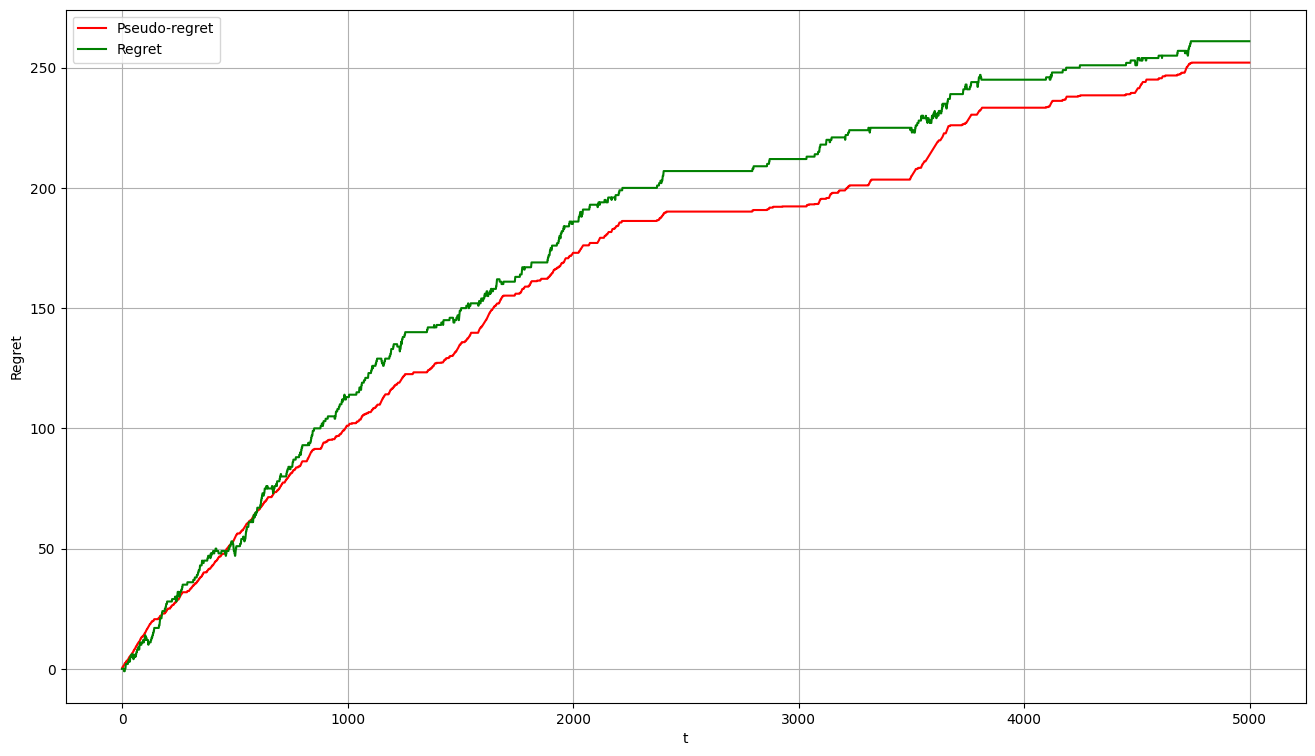

In [ ]:
plt.figure(figsize=(16,9))
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(pseudo_regret), color='r', label='Pseudo-regret')
plt.plot(np.cumsum(regret), color='g', label='Regret')
plt.legend()
plt.grid()
plt.show()

Notice that the expected pseudo-regret is monotonically increasing over time, and, conversely, the regret might also decrease.

However, to evaluate the performance of our approach in the correct way we also have to average between multiple runs, in order to take into account the  of the environment randomness. To evalate the uncertainty of the estimates, we also add the $95\%$ confidence intervals.

In [ ]:
n_repetitions = 5
regrets, pseudo_regrets = np.zeros((n_repetitions, T)), np.zeros((n_repetitions, T))
for i in range(n_repetitions):
  regrets[i], pseudo_regrets[i] = UCB1()

In [ ]:
# Compute the cumulative sum
cumu_regret = np.cumsum(regrets, axis=1)
cumu_pseudo_regret = np.cumsum(pseudo_regrets, axis=1)

# Take the average over different runs
avg_cumu_regret = np.mean(cumu_regret, axis=0)
avg_cumu_pseudo_regret = np.mean(cumu_pseudo_regret, axis=0)

std_cumu_regret = np.std(cumu_regret, axis=0)
std_cumu_pseudo_regret = np.std(cumu_pseudo_regret, axis=0)

We also want to understand wheter we are respecting the UCB1 upper bound:
	$$L_T \leq  8 \log T \sum_{a_i \in \mathcal{A}: \Delta_i > 0} \frac{1}{\Delta_i} + \left(1 + \frac{\pi^2}{3} \right) \sum_{a_i \in \mathcal{A}: \Delta_i > 0} \Delta_i$$

In [ ]:
ucb1_upper_bound = np.array([8*np.log(t)*sum(1/deltas) + (1 + np.pi**2/3)*sum(deltas)
                             for t in range(1,T+1)])

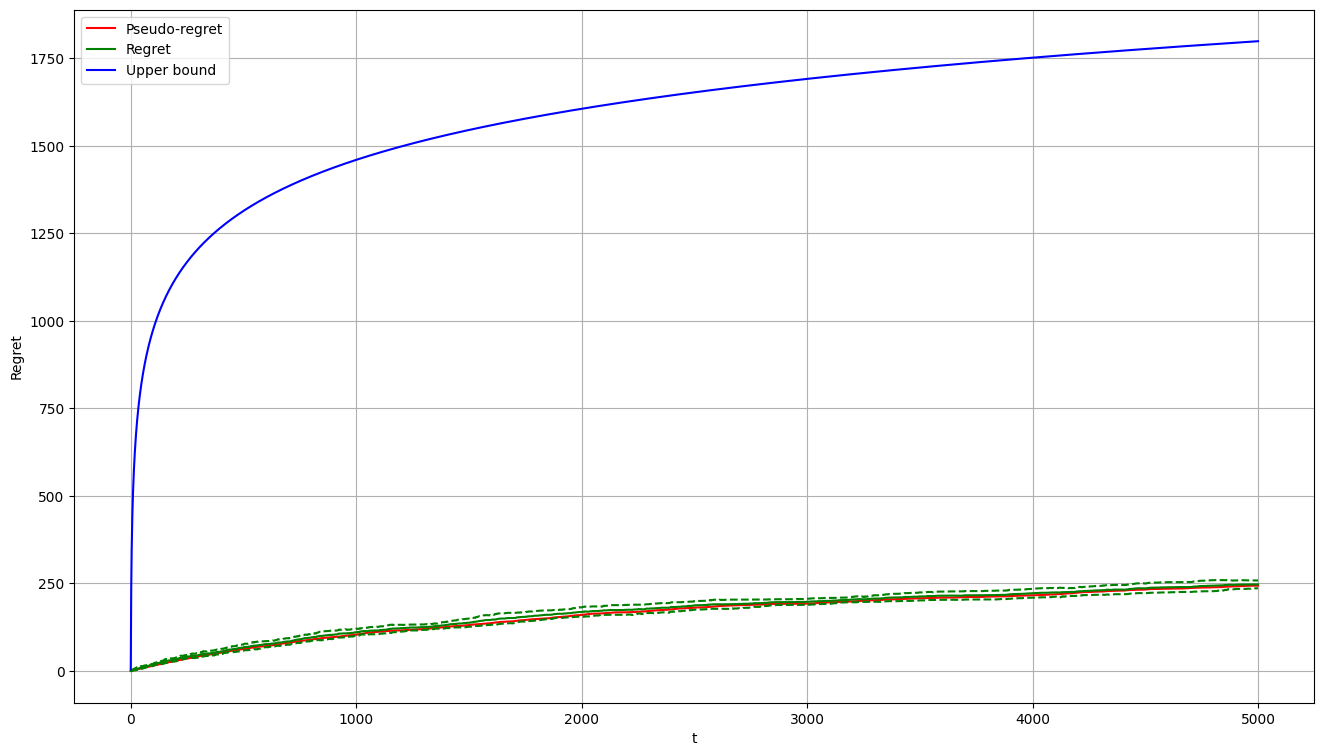

In [ ]:
plt.figure(figsize=(16,9))
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(avg_cumu_pseudo_regret, color='r', label='Pseudo-regret')

plt.plot(avg_cumu_regret + 1.96 * std_cumu_regret / np.sqrt(n_repetitions), linestyle='--', color='g')
plt.plot(avg_cumu_regret, color='g', label='Regret')
plt.plot(avg_cumu_regret - 1.96 * std_cumu_regret / np.sqrt(n_repetitions), linestyle='--', color='g')
plt.plot(ucb1_upper_bound, color='b', label='Upper bound')

plt.legend()
plt.grid()
plt.show()

##Thompson Sampling
In this second example we are resorting to a Bayesian method.
For each arm we use a uniform distribution as prior for the expected value of the reward, i.e., $\mu_i \sim Beta(1, 1) = U([0, 1])$.
During the learning process we update the beta distribution using the posterior provided by the reward:
*   if we observe a success: we update the $\alpha$ parameter of the Beta increasing its value by one
*   if we observe a failure: we update the $\beta$ parameter of the Beta increasing its value by one

Formally:




In [ ]:
def thompson_sampling():
  T = 5000
  beta_parameters = np.ones((n_arms,2))

  regret = np.array([])
  pseudo_regret = np.array([])

  for t in range(1,T+1):
      #Select an arm
      samples = np.random.beta(beta_parameters[:,0], beta_parameters[:,1])
      pulled_arm =  np.argmax(samples)

      #Pull an arm
      reward = np.random.binomial(1, exp_reward[pulled_arm]) #Bernoulli reward
      if pulled_arm != idx_opt:
        reward_opt = np.random.binomial(1, exp_reward[idx_opt])
      else:
        reward_opt = reward

      #Update TS
      beta_parameters[pulled_arm,0] =  beta_parameters[pulled_arm,0] + reward
      beta_parameters[pulled_arm,1] =  beta_parameters[pulled_arm,1] + 1.0 - reward

      #Store results
      regret = np.append(regret, reward_opt - reward)
      pseudo_regret = np.append(pseudo_regret, opt - exp_reward[pulled_arm])
  return regret, pseudo_regret, beta_parameters

As before, we start analysing the single run

In [ ]:
regret, pseudo_regret, beta_parameters = thompson_sampling()

In [ ]:
print(beta_parameters)

Notice how the parameters for the arms with larger expected rewards have larger values, meaning that during the learning process we selected those arms more often than the others.

An example of the execution of the TS algorithm is available at:
https://drive.google.com/file/d/1CC1YVM06-AEWQ71dXxoZPNBDUZpjeWSo/view?usp=sharing

In [ ]:
from scipy.stats import beta
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
x = np.linspace(0,1,1000)
colors = ['red', 'green', 'blue', 'purple', 'orange']
for params, rew, color in zip(beta_parameters, exp_reward, colors):
  rv = beta(*params)
  plt.plot(x, rv.pdf(x), color=color)
  plt.axvline(rew, linestyle='--', color=color)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(16,9))
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(pseudo_regret), label='Pseudo-regret', color='r')
plt.plot(np.cumsum(regret), label='Regret', color='g')
plt.legend()
plt.grid()
plt.show()

In [ ]:
n_repetitions = 5
regrets, pseudo_regrets = np.zeros((n_repetitions, T)), np.zeros((n_repetitions, T))
for i in range(n_repetitions):
  regrets[i], pseudo_regrets[i], _ = thompson_sampling()

# Compute the cumulative sum
cumu_regret = np.cumsum(regrets, axis=1)
cumu_pseudo_regret = np.cumsum(pseudo_regrets, axis=1)

# Take the average over different runs
avg_cumu_regret = np.mean(cumu_regret, axis=0)
avg_cumu_pseudo_regret = np.mean(cumu_pseudo_regret, axis=0)

std_cumu_regret = np.std(cumu_regret, axis=0)
std_cumu_pseudo_regret = np.std(cumu_pseudo_regret, axis=0)

In [ ]:
plt.figure(figsize=(16,9))
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(avg_cumu_pseudo_regret, color='r', label='pseudo-regret')
plt.plot(avg_cumu_regret + std_cumu_regret, linestyle='--', color='g')
plt.plot(avg_cumu_regret, color='g', label='regret')
plt.plot(avg_cumu_regret - std_cumu_regret, linestyle='--', color='g')
plt.legend()
plt.grid()
plt.show()

# Homeworks

##MAB Lower bound

Visualize the regret Lower bound for stochastic MAB problems.
Check if there exists a Lower bound which does not requires to know the distribution, i.e., that does not require to know the arms' gaps $\Delta_i$ and visualize it.


In [ ]:
# TODO

## Thompson Sampling Upper Bound
Visualize the pseudo regret and the Upper bound for the considered problem provided by TS algorithm.

In [ ]:
# TODO

## Adversarial MAB

Model an adversarial MAB environment with $5$ arms and $\{0,1\}$ rewards. A suggestion is to consider an adversary which decides the rewards for all the rounds in advance.

In [ ]:
# TODO

## EXP3

Implement the EXP3 algorithm for adversarial bandit defined in the MAB setting defined before. Compute the expected regret and compare it with the theoretical upper and lower bounds.

In [ ]:
# TODO